# Projet 5: Segmentez les clients d'un site e-commerce (modélisation)

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation des données](#data)
3. [K-means sur les indicateurs RFM](#kmrfm)
4. [DBSCAN sur les indicateurs RFM](#dbscan)
5. [K-means sur ACP](#kmacp)
6. [K-means sur variables les plus différenciantes](#km)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
# Pour vérifier si la convention PEP8 est respectée
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter
from math import pi

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# Configuration générale des graphiques
parameters = {'axes.labelsize': 13,
              'axes.titlesize': 16,
              'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
# pd.options.display.float_format = '{:20,.2f}'.format

## Chargement et visualisation des données <a class="anchor" id="data"></a>

In [3]:
# Import de la table des données par customer_unique_id
df_customers = pd.read_csv('data/df_customers.csv')

## K-means sur les indicateurs RFM <a class="anchor" id="kmrfm"></a>

Dans cette partie, nous allons regrouper les lignes, c'est-à-dire que nous allons créer des groupes d'individus : nous allons partitionner les données.

Comme les individus d'un même groupe sont similaires, on peut parfois se contenter d'étudier les caractéristiques du groupe plutôt que d'étudier chacun des individus qui le composent.

Autrement dit, cela revient à étudier les caractéristiques de "l'individu moyen" de chaque groupe.

En faisant cela, on perd forcément de l'information, car même si 2 individus d'un même groupe sont similaires, ils ne sont pas totalement identiques : il y a de la variabilité au sein des groupes.

Le challenge sera donc de trouver des méthodes qui font perdre le moins d'information possible. Il nous faut donc un critère pour évaluer la qualité d'une partition.

On ne va pas mesurer l'inertie du nuage de points tout entier, mais celle des différents nuages correspondant à chaque groupe.

Rappelons-nous les critères d'une bonne partition. On veut que les groupes (aussi appelés clusters) soient :

- resserrés sur eux-mêmes : deux points qui sont proches devraient appartenir au même groupe => inertie intracalasse faible
- loin les uns des autres, c'est-à-dire qu'ils soient fortement différenciés => inertie interclasse forte

Inertie totale = inertie intraclasse + inertie interclasse

https://www.naftaliharris.com/blog/visualizing-k-means-clustering/

In [4]:
# Sélection des données
df_clust_RFM = df_customers.set_index(['customer_unique_id'])[
    ['Recency', 'Frequency', 'Monetary']]

In [5]:
df_clust_RFM.head()

Recency  Frequency  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      113          1    129.90
0000b849f77a49e4a4ce2b2a4ca5be3f      116          1     18.90
0000f46a3911fa3c0805444483337064      539          1     69.00
0000f6ccb0745a6a4b88665a16c9f078      323          1     25.99
0004aac84e0df4da2b147fca70cf8255      290          1    180.00

In [6]:
# Standardisation des données
scaler = StandardScaler()
df_clust_RFM_std = scaler.fit_transform(df_clust_RFM)

In [7]:
# Détermination du nombre de clusters
wcss = []
for i in range(1, 11):
    kmeans_RFM = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_RFM.fit(df_clust_RFM_std)
    wcss.append(kmeans_RFM.inertia_)

Text(0.5, 1.0, 'Détermination du nombre de clusters avec K-means')

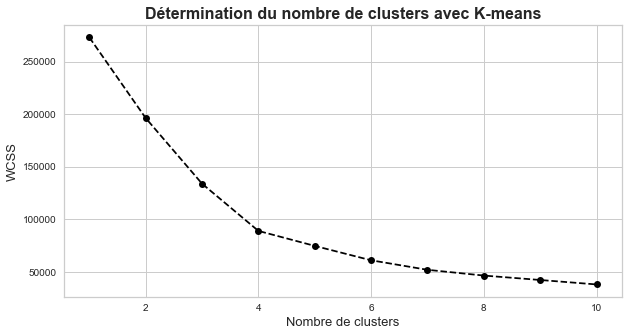

In [8]:
# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', color='black', linestyle='--')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.title('Détermination du nombre de clusters avec K-means')

Après avoir exécuté l'algorithme avec un nombre différent de clusters (10 clusters), nous déterminons le Within Cluster Sum of Squares (WCSS ou variance) pour chaque solution. Nous nous basons ensuite sur la méthode du coude pour définir le nombre de clusters optimal. Le coude se situe ici aux alentours de 4 clusters.

Une autre façon de quantifier à quel point un clustering répond aux exigences d'homogénéité et de séparation est de mesurer ce que l'on appelle le **coefficient de silhouette**. 

Pour un point x donné, le coefficient de silhouette s(x) permet d'évaluer si ce point appartient au « bon » cluster : 
- est-il proche des points du cluster auquel il appartient ? 
- est-il loin des autres points ? 

Pour répondre à la première question, on calcule la distance moyenne de x à tous les autres points du cluster C_k auquel il appartient.

Pour répondre à la deuxième, on calcule la plus petite valeur que pourrait prendre a(x), si x était assigné à un autre cluster.

Si x a été correctement assigné, alors a(x) < b(x). Le coefficient de silhouette est donc compris entre -1 et 1, et d'autant plus proche de 1 que l'assignation de x à son cluster est satisfaisante. Pour évaluer un clustering, on peut calculer son coefficient de silhouette moyen.

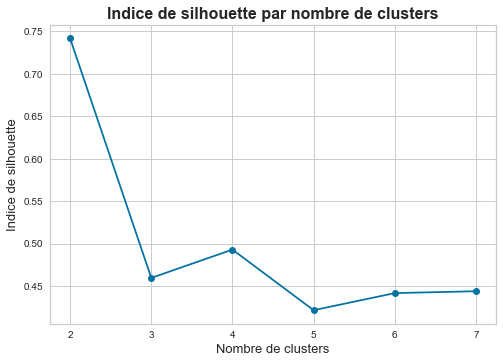

In [9]:
silhouettes_RFM = []
for nb_clusters in range(2, 8):
    cls_rfm = KMeans(n_clusters=nb_clusters, init='k-means++', random_state=42)
    cls_rfm.fit(df_clust_RFM_std)
    silh = silhouette_score(df_clust_RFM_std, cls_rfm.labels_)
    silhouettes_RFM.append(silh)

plt.plot(range(2, 8), silhouettes_RFM, marker='o')
plt.xticks(range(2, 8))
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de silhouette')
plt.title("Indice de silhouette par nombre de clusters")
plt.show()

Une segmentation avec 2 clusters serait beaucoup trop "pauvre", nous retenons ici aussi un nombre de 4 clusters.

In [10]:
# Initialisation du KMeans avec 4 clusters
kmeans_RFM = KMeans(n_clusters=4, init='k-means++', random_state=42)

In [11]:
# Kmeans sur données RFM standardisées
kmeans_RFM.fit(df_clust_RFM_std)

KMeans(n_clusters=4, random_state=42)

In [12]:
# Ajout des clusters dans le dataframe
df_clust_RFM['Clusters_kmeans_RFM'] = kmeans_RFM.labels_

In [13]:
df_clust_RFM.head()

Recency  Frequency  Monetary  \
customer_unique_id                                               
0000366f3b9a7992bf8c76cfdf3221e2      113          1    129.90   
0000b849f77a49e4a4ce2b2a4ca5be3f      116          1     18.90   
0000f46a3911fa3c0805444483337064      539          1     69.00   
0000f6ccb0745a6a4b88665a16c9f078      323          1     25.99   
0004aac84e0df4da2b147fca70cf8255      290          1    180.00   

                                  Clusters_kmeans_RFM  
customer_unique_id                                     
0000366f3b9a7992bf8c76cfdf3221e2                    1  
0000b849f77a49e4a4ce2b2a4ca5be3f                    1  
0000f46a3911fa3c0805444483337064                    3  
0000f6ccb0745a6a4b88665a16c9f078                    3  
0004aac84e0df4da2b147fca70cf8255                    3

In [14]:
df_clust_RFM['Clusters_kmeans_RFM'].unique()

array([1, 3, 2, 0])

In [15]:
# Création d'une nouvelle colonne avec les clusters sous forme de str
df_clust_RFM['Clusters'] = df_clust_RFM['Clusters_kmeans_RFM'].map({
    0: 'Cluster_1',
    1: 'Cluster_2',
    2: 'Cluster_3',
    3: 'Cluster_4'})

In [16]:
# Fonction permettant de rajouter les étiquettes en haut de chaque barre

def etiquette_v(ax, espace=5):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot vertical.

    Arguments:
        ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes
            du plot à annoter.
        espace (int): distance entre les étiquettes et les barres.
    """

    # Pour chaque barre, placer une étiquette
    for rect in ax.patches:
        # Obtenir le placement de X et Y de l'étiquette à partir du rectangle
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Espace entre la barre et le label
        space = espace
        # Alignement vertical
        va = 'bottom'

        # Si la valeur est négative, placer l'étiquette sous la barre
        if y_value < 0:
            # Valeur opposer de l'argument espace
            space *= -1
            # Alignement vertical 'top'
            va = 'top'

        # Utiliser la valeur Y comme étiquette avec 0 décimale
        label = "{:.0f}".format(y_value)

        # Créer l'annotation
        ax.annotate(
            label,
            (x_value, y_value),
            xytext=(0, space),
            textcoords="offset points",
            ha='center',
            va=va)

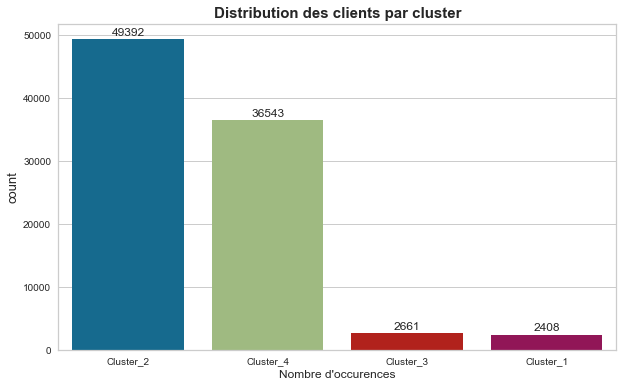

In [17]:
# Distribution des clients par cluster
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Clusters', data=df_clust_RFM,
                   order=df_clust_RFM['Clusters'].value_counts().index)
plt.title('Distribution des clients par cluster',
          fontweight='bold',
          fontsize=15)
plt.xlabel("Nombre d'occurences", fontsize=12)
etiquette_v(ax, 2)

Le cluster 2 est clairement le plus représenté suivi du cluster 4 puis 3 et 1 avec un nombre d'occurences beaucoup plus faible. Pour comprendre la composition des clusters, nous allons représenter la distribution des clients de chaque cluster en fonction des variables RFM.

In [18]:
%pycodestyle_off
def bivariate_plots_box(dataframe, var_quali, liste_var_quanti,
                        nb_lignes, nb_col):

    for i, c in enumerate(liste_var_quanti, 1):
        ax = fig.add_subplot(nb_lignes, nb_col, i)
        meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
        ax = sns.boxplot(data = dataframe, y = c, x = var_quali, showfliers=False,  showmeans=True, meanprops=meanprops)
        plt.suptitle(f'Dispersion des variables RFM en fonction des {var_quali}', fontsize=16,
                     fontweight='bold')

        ax.title.set_fontweight('bold')
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [l[0:10]+'.' if len(l)>10 else l for l in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show()
%pycodestyle_on

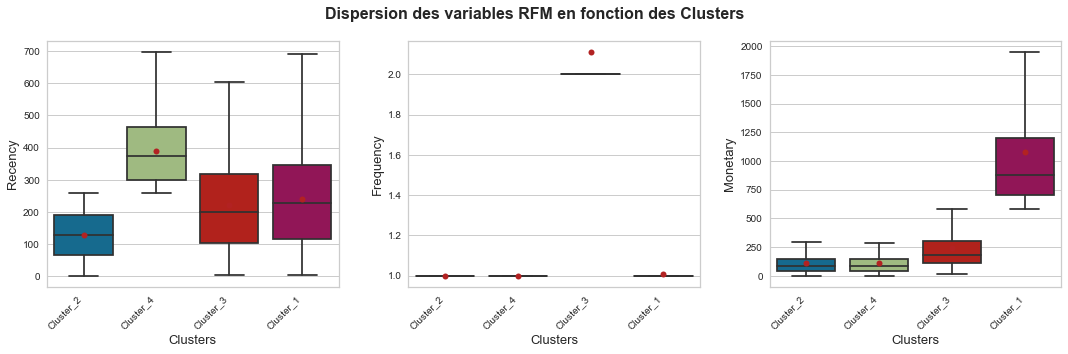

In [19]:
var_RFM = ['Recency', 'Frequency', 'Monetary']

fig = plt.figure(figsize=(15, 5))
bivariate_plots_box(df_clust_RFM, 'Clusters', var_RFM, 1, 3)

- Le cluster 1 représente les clients qui ont passé une seule commande avec un montant élevé
- Le cluster 2 représente les clients qui ont passé une seule commande de faible montant mais plus recemment
- Le cluster 3 représente les clients qui ont passé plusieurs commandes
- Le cluster 4 représente les clients qui ont passé une seule commande, de faible montant, il y a longtemps

## DBSCAN sur les indicateurs RFM <a class="anchor" id="dbscan"></a>

DBSCAN itère sur les points du jeu de données. Pour chacun des points qu'il analyse, il construit l'ensemble des points atteignables par densité depuis ce point : il calcule l'epsilon-voisinage de ce point, puis, si ce voisinage contient plus de n_min points, les epsilon-voisinages de chacun d'entre eux, et ainsi de suite, jusqu'à ne plus pouvoir agrandir le cluster. Si le point considéré n'est pas un point intérieur, c'est-à-dire qu'il n'a pas suffisamment de voisins, il sera alors étiqueté comme du bruit. Cela permet à DBSCAN d'être robuste aux données aberrantes puisque ce mécanisme les isole.

L'algorithme DBSCAN est difficile à utiliser en très grande dimension : fléau de la dimensionalité. Les boules de rayon epsilon et de grande dimension ont tendance à ne contenir aucun autre point. **Nous allons donc partir sur un dataset réduit pour tester cet alhorithme**.

Le choix des paramètres epsilon et n_min peut aussi être délicat : il faut veiller à utiliser des paramètres qui permettent de créer suffisamment de points intérieurs (ce qui n'arrivera pas si nmin est trop grand ou epsilon trop petit). En particulier, cela signifie que DBSCAN ne pourra pas trouver des clusters de densités différentes.

DBSCAN a le grand avantage d'être efficace en temps de calcul sans requérir de prédéfinir le nombre de clusters. Enfin, il permet de trouver des clusters de forme arbitraire.

https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

In [20]:
# Sélection des données et réduction du dataset
df_dbscan_RFM = df_customers.set_index(['customer_unique_id'])[
    ['Recency', 'Frequency', 'Monetary']]

df_dbscan_RFM = df_dbscan_RFM.sample(10000, random_state=42)

In [21]:
# Standardisation des données
scaler = StandardScaler()
df_dbscan_RFM_std = scaler.fit_transform(df_dbscan_RFM)

DBSCAN requiert les paramètres ε et minPts pour le clustering. Le paramètre minPts est facile à définir. Le minPts devrait être 4 pour un ensemble de données à deux dimensions. Pour les jeux de données multidimensionnels, minPts doit être égal à 2 * le nombre de dimensions. Ici, nous avons 3 dimensions, nous allons dont prendre minPts = 2 * 3 = 6.

Une autre question est de savoir quelle valeur optimale doit être utilisée pour le paramètre ε. Le paramètre ε est difficile à définir et dépend de la fonction de distance. Parfois, l'expertise du domaine est également nécessaire pour définir un paramètre ε. Le paramètre ε doit être aussi petit que possible.

Pour déterminer le paramètre ε optimal, nous allons calculer les distances entre les k plus proches voisins (kNN) (distance moyenne de chaque point de données par rapport à ses k plus proches voisins) d'un ensemble de données d'entrée en utilisant la méthode des k plus proches voisins.

La fonction NearestNeighbors requiert le paramètre n_neighbors (nombre de voisins), qui peut être le même que la valeur minPts.

In [22]:
# n_neighbors = 7 (6 + colonne composée de 0)
nbrs = NearestNeighbors(n_neighbors=7).fit(df_dbscan_RFM_std)
# trouver les k_neighbors d'un point
neigh_dist, neigh_ind = nbrs.kneighbors(df_dbscan_RFM_std)
# tri des distances entre voisins par ordre croissant
sort_neigh_dist = np.sort(neigh_dist, axis=0)

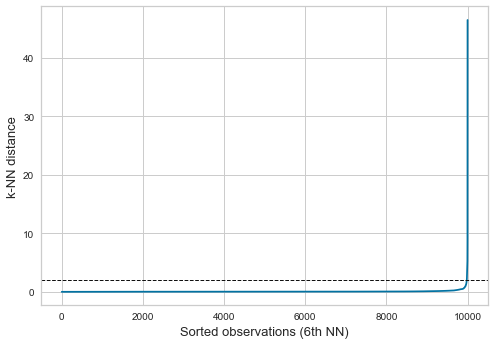

In [23]:
k_dist = sort_neigh_dist[:, 6]
plt.plot(k_dist)
plt.axhline(y=2, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (6th NN)")
plt.show()

D'après le graphique des distances k-NN, la valeur optimale de ε est de 2.
Les points inférieurs à 2 appartiennent à un cluster et ceux supérieurs à 2 sont du bruit ou des valeurs aberrantes.

Nous pouvons donc maintenant effectuer notre clustering par DBSCAN avec les paramètres ε et minPts trouvés précedemment.

In [24]:
# Initialisation du DBSCAN
dbscan_RFM = DBSCAN(eps=2, min_samples=6).fit(df_dbscan_RFM_std)
# cluster labels
dbscan_RFM_lab = dbscan_RFM.labels_
dbscan_RFM_lab

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [25]:
# unique clusters
set(dbscan_RFM_lab)
# -1 = bruit (non assigné à un cluster)

{-1, 0, 1, 2}

In [26]:
Counter(dbscan_RFM_lab)

Counter({0: 9710, 1: 262, 2: 18, -1: 10})

In [27]:
# Nombre de clusters (outliers non inclus)
n_clusters_ = len(set(dbscan_RFM_lab)) - (1 if -1 in dbscan_RFM_lab else 0)
n_noise_ = list(dbscan_RFM_lab).count(-1)

print("Nombre estimé de clusters: %d" % n_clusters_)
print("Nombre estimé d'outliers: %d" % n_noise_)

Nombre estimé de clusters: 3
Nombre estimé d'outliers: 10


Le clustering DBSCAN a identifié 3 clusters avec les paramètres donnés. Le plus grand cluster (0) compte 9710 points de données et le plus petit cluster (2) compte 18 points de données. 10 outliers ont été trouvés.

In [28]:
# Création d'un dataframe avec les variables originales + le cluster attribué
df_dbscan_RFM_clust = pd.concat([df_dbscan_RFM.reset_index(drop=False),
                                 pd.DataFrame(dbscan_RFM_lab)], axis=1)
df_dbscan_RFM_clust.rename(columns={0: 'Cluster'}, inplace=True)

In [29]:
# On transforme la colonne Cluster au format string
df_dbscan_RFM_clust["Cluster"] = df_dbscan_RFM_clust["Cluster"].astype(str)

In [30]:
df_dbscan_RFM_clust.head()

customer_unique_id  Recency  Frequency  Monetary Cluster
0  f243eed691a2628733a8f9d2ddd1d4bb      183          1    128.90       0
1  11d50f6650125d144e24ce5b8faa9c0d      231          1     78.00       0
2  0754be9928ac67162aba36894a7c5f22      116          1     99.99       0
3  f410e6ebfc47e16373907ddb53acbca5       31          1     44.99       0
4  2fd07dc5dbae616986e00fb72e7a779b      117          2    183.80       1

Text(0.5, 1.0, 'Distribution des clients par cluster')

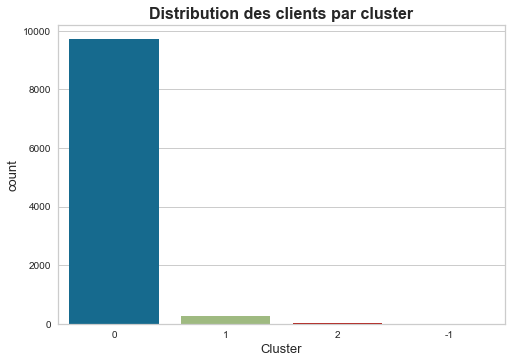

In [31]:
# Visualisation des clusters attribués
sns.countplot(x=df_dbscan_RFM_clust["Cluster"])
plt.title(f'Distribution des clients par cluster', fontsize=16,
          fontweight='bold')

In [32]:
# Visualisation du clustering effectué sur les variables RFM
fig = px.scatter_3d(df_dbscan_RFM_clust,
                    x='Recency',
                    y='Frequency',
                    z='Monetary',
                    color='Cluster',
                    color_discrete_map={'-1': 'red',
                                        '0': 'blue',
                                        '1': 'orange',
                                        '2': 'green'})
fig.show()

Le DBSCAN ne fonctionne pas sur ces données. Quasi tous les clients ont été attribués au cluster 0 avec seulement 10 outliers.

## K-means sur ACP <a class="anchor" id="kmacp"></a>

L’ACP, l’analyse en composantes principales, s’intéresse à des tableaux de données rectangulaires avec en lignes des individus et en colonnes des variables qui sont de nature quantitative. Donc on peut considérer qu’on a I individus et K variables.

Comme on ne peut pas représenter les données au delà de 3 dimensions, on passe par l’ACP pour réduire ce nombre de dimensions.

L’objectif de l’ACP est de trouver le meilleur plan appelé plan principal et les plans secondaires qui décrivent le mieux les données. Cette analyse vise à fournir un nuage de points qui résume au mieux les données :

- Un point = un individu
- Un axe = une combinaison d’informations

Autrement dit cette analyse permet de résumer l’information de plusieurs variables quantitatives mesurées sur un ensemble d’individus afin d’étudier :

- Les individus: lesquels se ressemblent ?
- Les variables: lesquelles sont liées ? indépendantes ?

Cette analyse peut mener à une caractérisation de groupe d’individus.

L'ACP est définie comme une transformation linéaire orthogonale qui transforme les données dans un nouveau système de coordonnées de telle sorte que la plus grande variance par une certaine projection scalaire des données se situe sur la première coordonnée (appelée première composante principale), la deuxième plus grande variance sur la deuxième coordonnée, et ainsi de suite.

L'analyse en composantes principales (ACP) est une technique qui transforme les données à haute dimension en données à plus faible dimension tout en conservant le plus d'informations possible.

Nous sélectionnons uniquement les données numériques afin de pouvoir réaliser l'Analyse en Composantes Principales. A noter que nous avons créé de nouvelles variables à partir notamment des différentes dates et de l'aggrégation des données des commandes.

#### ACP

In [33]:
# Sélection des données
numeric_features = ['Frequency', 'note_moy_com', 'facil_paiement_max_moy_com',
                    'nb_art_moy_com', 'nb_art_tot_ach', 'nb_art_diff_ach',
                    'Monetary', 'montant_moy_com', 'prix_trans_moy_com',
                    'prix_moy_art_com', 'prix_max_art', 'prix_min_art',
                    'jrs_livr_moy_com', 'respect_date_livr_moy_com',
                    'jrs_redac_review_moy_com', 'dist_cli_vend_moy_km',
                    'Recency']

df_clust_ACP = df_customers.set_index(['customer_unique_id'])[numeric_features]

In [34]:
# Preprocessing des données
col_transformer = ColumnTransformer(
                    transformers=[
                        ('ss', StandardScaler(), numeric_features),
                    ],
                    remainder='drop',
                    n_jobs=-1
                    )

df_clust_ACP_trans = col_transformer.fit_transform(df_clust_ACP)

In [35]:
# ACP
pca = PCA()
pca.fit(df_clust_ACP_trans)

PCA()

In [36]:
# Fonction qui affiche l'éboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

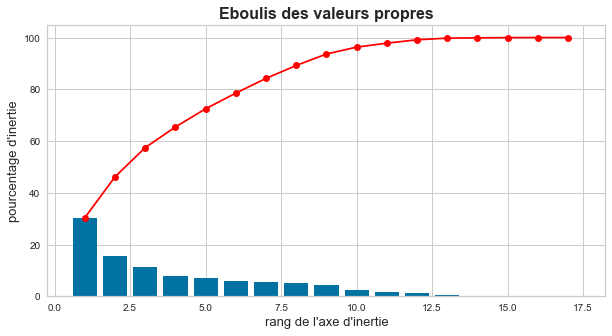

In [37]:
plt.figure(figsize=(10, 5))
display_scree_plot(pca)

Le graphique montre la quantité de variance capturée (sur l'axe des y) en fonction du nombre de composantes que nous incluons (sur l'axe des x). Une règle empirique consiste à préserver environ 80 % de la variance. Il faudrait donc garder 6 composantes.

Nous effectuons l'ACP avec le nombre de composantes choisi ci-dessus.

In [38]:
# ACP
pca = PCA(n_components=6)
pca.fit(df_clust_ACP_trans)

PCA(n_components=6)

Nous n'avons besoin que des scores calculés des composantes résultantes pour les éléments de notre ensemble de données :

In [39]:
scores_pca = pca.transform(df_clust_ACP_trans)
scores_pca

array([[ 0.01977132, -0.60326486, -0.61278571,  0.53038706, -0.62095697,
        -0.03783586],
       [-1.64636095, -0.3688895 , -0.49345998,  0.64377641, -1.38429546,
        -0.23047436],
       [-0.37703608, -0.33410408,  1.88320541,  0.20965421,  0.78221584,
         1.36970576],
       ...,
       [-0.53938889, -0.42419872, -0.47186376, -1.35968952,  2.45060068,
         0.4131624 ],
       [-0.17937345, -0.49410497, -0.42322774, -0.06639117,  0.077396  ,
        -0.61059587],
       [-0.93852282, -0.45462076, -0.84393802, -0.28612068,  0.7207355 ,
         0.94915218]])

<AxesSubplot:>

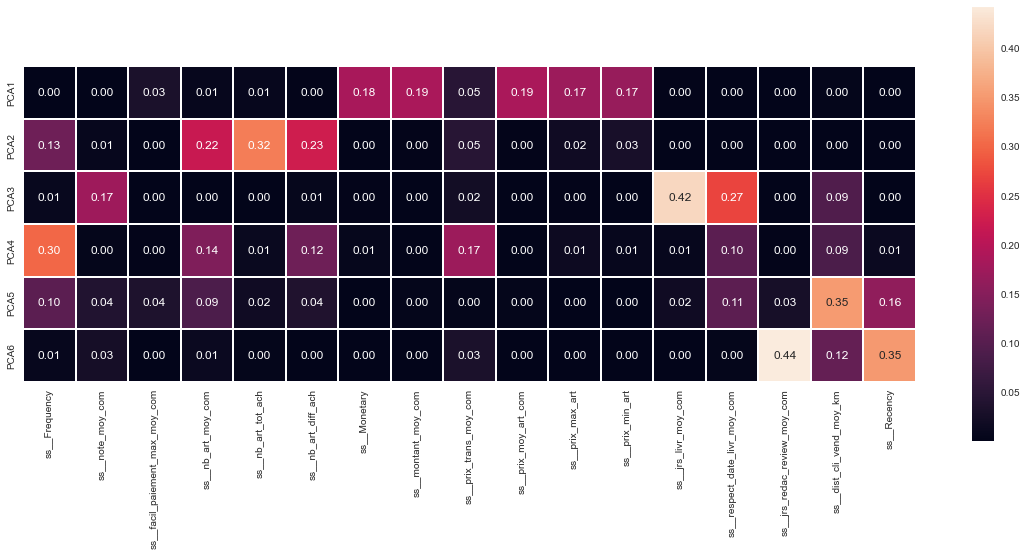

In [40]:
plt.figure(figsize=(20, 8))
sns.heatmap(pca.components_**2,
            yticklabels=["PCA"+str(x) for x in range(1, pca.n_components_+1)],
            xticklabels=list(col_transformer.get_feature_names_out()),
            annot=True,
            fmt='.2f',
            square=True,
            linewidths=0.05,
            cbar_kws={"orientation": "vertical"})

- La 1ère composante principale est constituée majoritairement du montant moyen des commandes, du prix moyen des articles, du montant total dépensé et des prix maximum et minimum des articles.
- La 2ème composante principale est constituée majoritairement du nombre d'articles achetés, du nombre d'articles différents achetés, du nombre moyen d'articles par commande et  du nombre total de commandes.
- La 3ème composante principale est constituée majoritairement du nombre de jours moyen de livraison, du respect de la date de livraison et de la note moyenne attribuée aux commandes.
- La 4ème composante principale est constituée majoritairement du nombre total de commandes, du coût du transport moyen, du nombre d'articles et d'articles différents par commande, du respect de la date de livraison et de la distance client / vendeur.
- La 5ème composante principale est constituée majoritairement de la distance entre le client et le vendeur, du nombre de jours depuis la dernière commande, et du respect de la date de livraison.
- La 6ème composante principale est constituée majoritairement du nombre de jours avant rédaction du commentaire client, du nombre de jours passés depuis la dernière commande et de la distance entre le client et le vendeur.

In [41]:
%pycodestyle_off

def display_circles(pcs, n_comp, pca, axis_ranks,
                    labels=None, label_rotation=0,
                    lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10, 10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
%pycodestyle_on

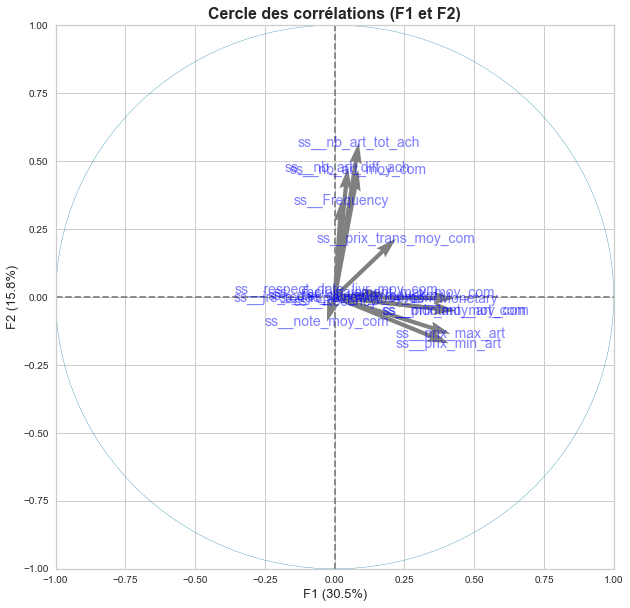

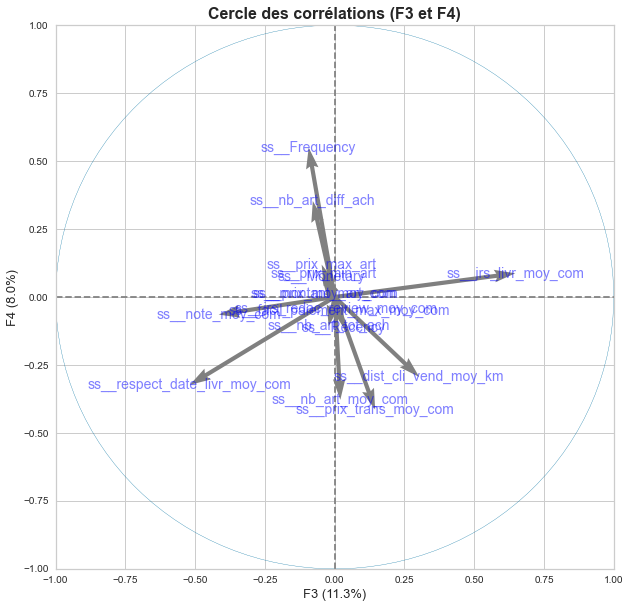

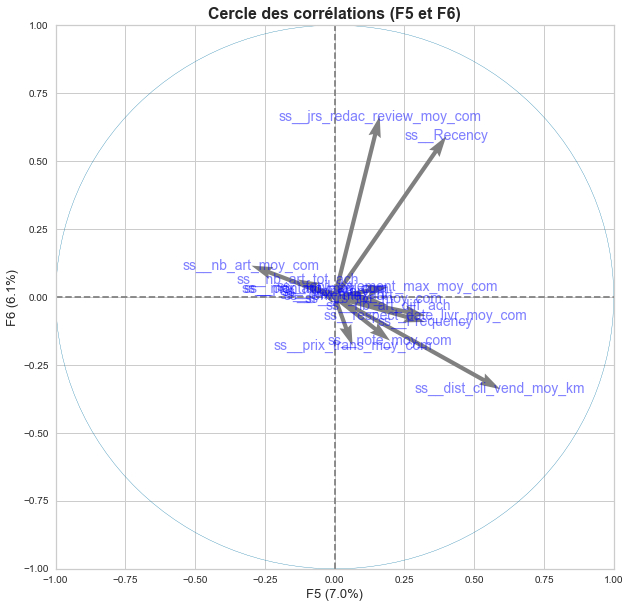

In [42]:
# Cercle des corrélations sur les 6 composantes principales
pcs = pca.components_
display_circles(pcs, 6, pca, [(0, 1), (2, 3), (4, 5)],
                labels=np.array(col_transformer.get_feature_names_out()))

Le premier axe semble représenter les **dépenses des clients** tandis que le deuxième axe nous renseigne plutôt sur le **nombre d'articles achetés par les clients**. Le troisième axe nous renseigne plutôt sur le **nombre de jours de livraison moyen et au respect de la date de livraison (liées à la note attribuée à la commande)**. Le quatrième axe nous donne des indications sur le **nombre de commandes / nombre d'articles différents achetés par les clients**. 
Le cinquième axe représente la **distance entre le client et le vendeur** alors que le sixième axe nous renseigne sur le **temps moyen mis par le client pour rédiger un commentaire / nombre de jours passés depuis la dernière commande**

In [43]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks,
                             labels=None, alpha=1, illustrative_var=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(10, 10))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2],
                            alpha=alpha, s=200)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1],
                                X_projected[selected, d2],
                                alpha=alpha,
                                label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i],
                             fontsize='14',
                             ha='center',
                             va='bottom')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("Project individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [44]:
# Sélection de 5 individus à afficher
df_clust_ACP[100:105][['montant_moy_com',
                       'nb_art_tot_ach', 'nb_art_diff_ach', 'nb_art_moy_com',
                       'jrs_livr_moy_com',
                       'Frequency',
                       'dist_cli_vend_moy_km',
                       'jrs_redac_review_moy_com', 'Recency']]

montant_moy_com  nb_art_tot_ach  \
customer_unique_id                                                  
004177f7bf62929186b32c7fdaa6157b          393.980             2.0   
004256f082951ec189a4962b6788c214          245.000             1.0   
004288347e5e88a27ded2bb23747066c          158.945             2.0   
0042dcca0ae57aaec6e808edc31a2d48           69.800             1.0   
0042dfa8925d6eb23e471ec350454f04           49.900             1.0   

                                  nb_art_diff_ach  nb_art_moy_com  \
customer_unique_id                                                  
004177f7bf62929186b32c7fdaa6157b              1.0             2.0   
004256f082951ec189a4962b6788c214              1.0             1.0   
004288347e5e88a27ded2bb23747066c              2.0             1.0   
0042dcca0ae57aaec6e808edc31a2d48              1.0             1.0   
0042dfa8925d6eb23e471ec350454f04              1.0             1.0   

                                  jrs_livr_moy_com  Frequency  \
customer_unique_id                                              
004177f7bf62929186b32c7fdaa6157b              18.0          1   
004256f082951ec189a4962b6788c214              12.0          1   
004288347e5e88a27ded2bb23747066c               6.5          2   
0042dcca0ae57aaec6e808edc31a2d48              13.0          1   
0042dfa8925d6eb23e471ec350454f04               7.0          1   

                                  dist_cli_vend_moy_km  \
customer_unique_id                                       
004177f7bf62929186b32c7fdaa6157b            315.794642   
004256f082951ec189a4962b6788c214             74.787302   
004288347e5e88a27ded2bb23747066c            326.803478   
0042dcca0ae57aaec6e808edc31a2d48            861.027959   
0042dfa8925d6eb23e471ec350454f04            439.539085   

                                  jrs_redac_review_moy_com  Recency  
customer_unique_id                                                   
004177f7bf62929186b32c7fdaa6157b                       0.0      316  
004256f082951ec189a4962b6788c214                       3.0      161  
004288347e5e88a27ded2bb23747066c                       1.0      229  
0042dcca0ae57aaec6e808edc31a2d48                       2.0      272  
0042dfa8925d6eb23e471ec350454f04                       0.0       37

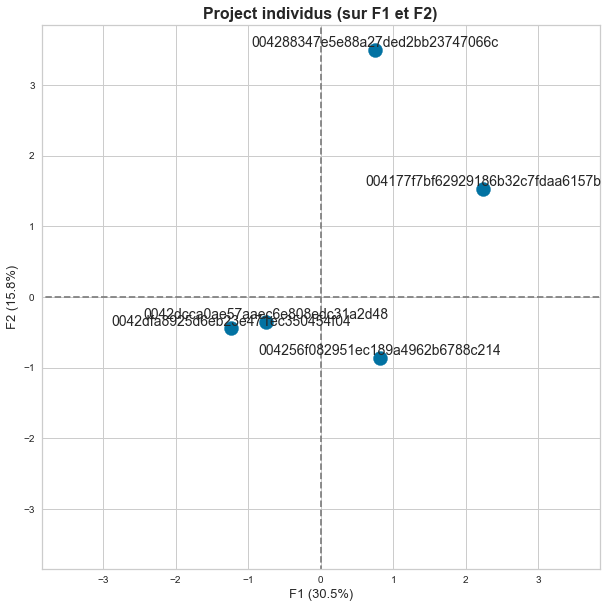

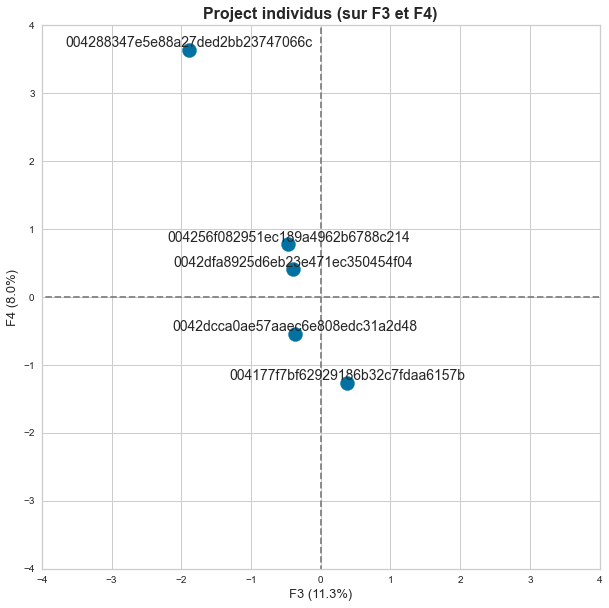

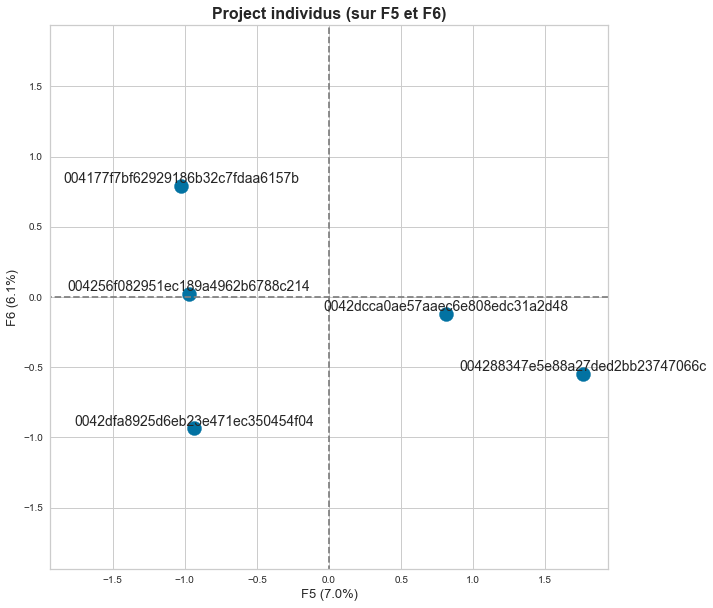

In [45]:
# Projection des individus sur les 6 composantes principales
names = df_clust_ACP.index.get_level_values("customer_unique_id")[100:105]
display_factorial_planes(scores_pca[100:105], 6,
                         pca, [(0, 1), (2, 3), (4, 5)],
                         labels=np.array(names))

La projection des individus permet de vérifier que notre interprétation est la bonne:

- axe 1: le client 004177f7bf62929186b32c7fdaa6157b a bien dépensé plus que les autres clients
- axe 2: le client 004288347e5e88a27ded2bb23747066c a acheté plus d'articles et notamment des articles différents que les autres clients
- axe 3: le client 004288347e5e88a27ded2bb23747066c est bien livré plus rapidement que les autres clients
- axe 4: le client 004288347e5e88a27ded2bb23747066c a bien passé plus de commandes que les autres clients
- axe 5: la distance moyenne du client 0042dcca0ae57aaec6e808edc31a2d48 avec son vendeur est plus importante que celle du client 004256f082951ec189a4962b6788c214 avec son vendeur.
- axe 6: le client 0042dfa8925d6eb23e471ec350454f04 met moins de jours a rédiger un commentaire que le client 004177f7bf62929186b32c7fdaa6157b.

Notre interprétation semble cohérente.

Nous allons maintenant incorporer les scores PCA nouvellement obtenus dans l'algorithme K-means. C'est ainsi que nous pouvons effectuer une segmentation basée sur les scores des composantes principales au lieu des caractéristiques originales.

#### K-Means

Il existe diverses raisons d'utiliser une étape de réduction de la dimensionnalité telle que l'ACP avant la segmentation des données. La principale d'entre elles est qu'en réduisant le nombre de caractéristiques, nous améliorons les performances de notre algorithme. De plus, en diminuant le nombre de caractéristiques, le bruit est également réduit.

In [46]:
# Détermination du nombre de clusters
wcss = []
for i in range(1, 11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

Text(0.5, 1.0, 'K-means avec ACP clustering')

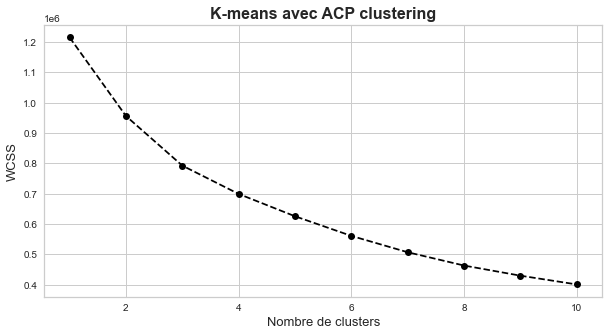

In [47]:
# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', color='black', linestyle='--')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.title('K-means avec ACP clustering')

Après avoir exécuté l'algorithme avec un nombre différent de clusters (10 clusters), nous déterminons le Within Cluster Sum of Squares (WCSS ou variance) pour chaque solution. Nous nous basons ensuite sur la méthode du coude pour définir le nombre de clusters optimal. Le coude se situe ici aux alentours de 4 clusters.

In [48]:
# Initialisation du KMeans avec 4 clusters
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)

In [49]:
# Kmeans sur données de l'ACP
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [50]:
# Création d'un nouveau dataframe avec les variables originales
# Ajout des scores de l'ACP et les clusters
df_segm_pca_kmeans = pd.concat([df_clust_ACP.reset_index(drop=False),
                                pd.DataFrame(scores_pca)],
                               axis=1)
df_segm_pca_kmeans.columns.values[-6:] = ['ACP1_Depenses',
                                          'ACP2_Nb_Articles',
                                          'ACP3_Livraison',
                                          'ACP4_Nb_Commandes',
                                          'ACP5_Distance_Cli_Vend',
                                          'ACP6_Jrs_Review']
df_segm_pca_kmeans['Clusters_kmeans_PCA'] = kmeans_pca.labels_

In [51]:
# Création d'une nouvelle colonne avec les clusters sous forme de str
df_segm_pca_kmeans['Cluster'] = df_segm_pca_kmeans['Clusters_kmeans_PCA'].map({
    0: 'Cluster_1',
    1: 'Cluster_2',
    2: 'Cluster_3',
    3: 'Cluster_4'})

In [52]:
df_segm_pca_kmeans.head()

customer_unique_id  Frequency  note_moy_com  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1           5.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1           4.0   
2  0000f46a3911fa3c0805444483337064          1           3.0   
3  0000f6ccb0745a6a4b88665a16c9f078          1           4.0   
4  0004aac84e0df4da2b147fca70cf8255          1           5.0   

   facil_paiement_max_moy_com  nb_art_moy_com  nb_art_tot_ach  \
0                         8.0             1.0             1.0   
1                         1.0             1.0             1.0   
2                         8.0             1.0             1.0   
3                         4.0             1.0             1.0   
4                         6.0             1.0             1.0   

   nb_art_diff_ach  Monetary  montant_moy_com  prix_trans_moy_com  \
0              1.0    129.90           129.90               12.00   
1              1.0     18.90            18.90                8.29   
2              1.0     69.00            69.00               17.22   
3              1.0     25.99            25.99               17.63   
4              1.0    180.00           180.00               16.89   

   prix_moy_art_com  prix_max_art  prix_min_art  jrs_livr_moy_com  \
0            129.90        129.90        129.90               6.0   
1             18.90         18.90         18.90               3.0   
2             69.00         69.00         69.00              25.0   
3             25.99         25.99         25.99              20.0   
4            180.00        180.00        180.00              13.0   

   respect_date_livr_moy_com  jrs_redac_review_moy_com  dist_cli_vend_moy_km  \
0                        4.0                       4.0            110.459074   
1                        4.0                       0.0             22.219469   
2                        1.0                       1.0            516.692345   
3                       11.0                       1.0           2479.683397   
4                        7.0                       4.0            154.421184   

   Recency  ACP1_Depenses  ACP2_Nb_Articles  ACP3_Livraison  \
0      113       0.019771         -0.603265       -0.612786   
1      116      -1.646361         -0.368889       -0.493460   
2      539      -0.377036         -0.334104        1.883205   
3      323      -0.917406         -0.260050        1.679961   
4      290       0.506048         -0.684596       -0.261348   

   ACP4_Nb_Commandes  ACP5_Distance_Cli_Vend  ACP6_Jrs_Review  \
0           0.530387               -0.620957        -0.037836   
1           0.643776               -1.384295        -0.230474   
2           0.209654                0.782216         1.369706   
3          -1.022972                2.336035        -0.856419   
4           0.367466               -0.079896         0.551907   

   Clusters_kmeans_PCA    Cluster  
0                    3  Cluster_4  
1                    3  Cluster_4  
2                    0  Cluster_1  
3                    0  Cluster_1  
4                    3  Cluster_4

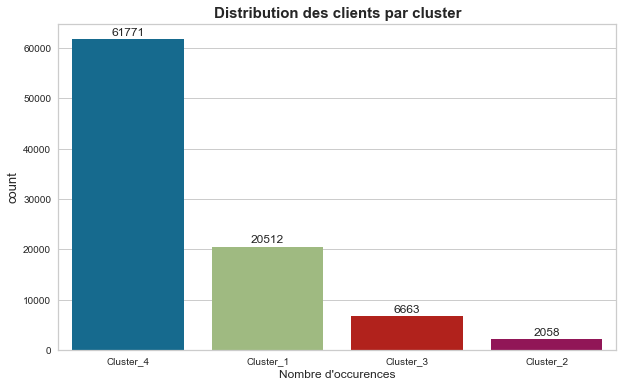

In [53]:
# Distribution des clients par cluster
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Cluster', data=df_segm_pca_kmeans,
                   order=df_segm_pca_kmeans['Cluster'].value_counts().index)
plt.title('Distribution des clients par cluster',
          fontweight='bold',
          fontsize=15)
plt.xlabel("Nombre d'occurences", fontsize=12)
etiquette_v(ax, 2)

Le cluster 4 est clairement le plus représenté suivi des clusters 1 et 3. Pour comprendre la composition des clusters, nous allons représenter la distribution des aliments de chaque cluster en fonction des variables principales.

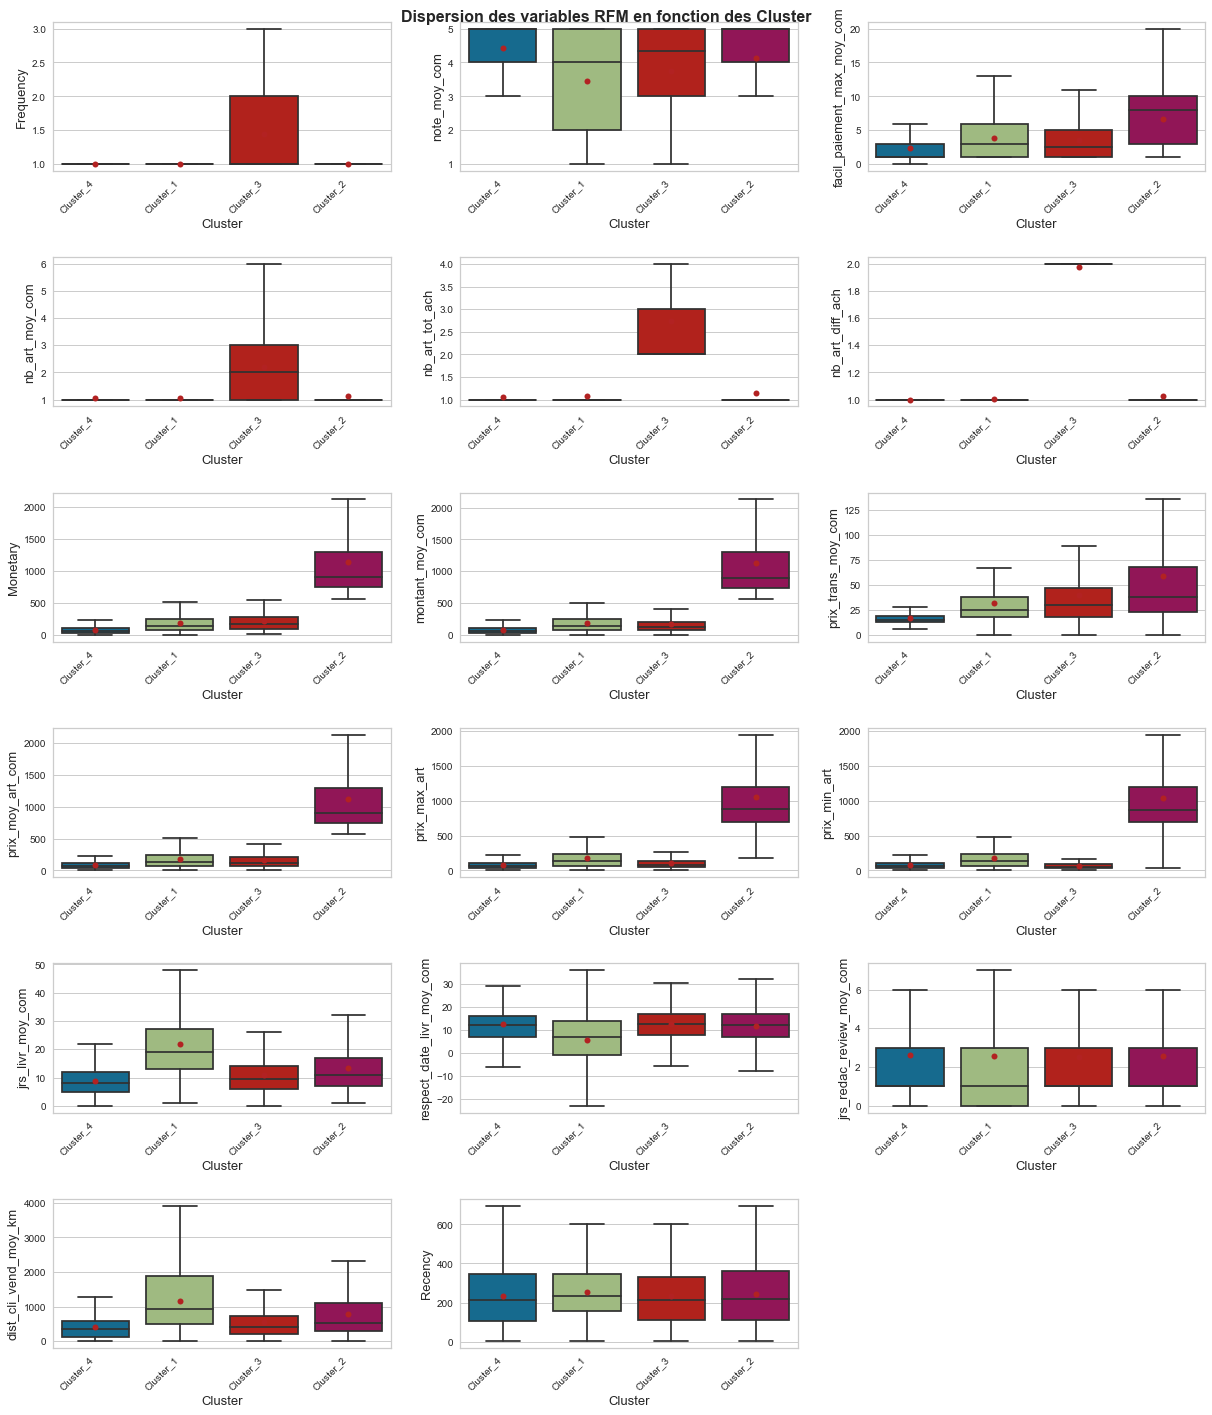

In [54]:
fig = plt.figure(figsize=(17, 20))
bivariate_plots_box(df_segm_pca_kmeans, 'Cluster', numeric_features, 6, 3)

- Le cluster 1 représente les clients les **moins satisfaits** avec un nombre de jours de livraison supérieur aux autres clients et ayant effectué une seule commande.
- Le cluster 2 représente les clients qui ont **dépensé le plus** et qui ont effectué une seule commande.
- Le cluster 3 représente les clients qui ont passé **plus d'une commande**
- Le cluster 4 représente les clients les **plus satisfaits** mais ayant effectué une seule commande.

## K-means sur variables les plus différenciantes <a class="anchor" id="km"></a>

Nous avons vu précédemment que certaines variables ne permettent pas de différencier nos clusters. Nous allons nous baser cette fois ci sur les variables RFM qui sont utilisées frequemment en marketing en rajoutant les variables les plus différenciantes.

In [55]:
# Sélection des données
df_clust = df_customers.set_index(['customer_unique_id'])[
    ['Recency', 'Frequency', 'Monetary', 'note_moy_com',
     'jrs_livr_moy_com', 'nb_art_moy_com']]

In [56]:
df_clust.head()

Recency  Frequency  Monetary  note_moy_com  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      113          1    129.90           5.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      116          1     18.90           4.0   
0000f46a3911fa3c0805444483337064      539          1     69.00           3.0   
0000f6ccb0745a6a4b88665a16c9f078      323          1     25.99           4.0   
0004aac84e0df4da2b147fca70cf8255      290          1    180.00           5.0   

                                  jrs_livr_moy_com  nb_art_moy_com  
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2               6.0             1.0  
0000b849f77a49e4a4ce2b2a4ca5be3f               3.0             1.0  
0000f46a3911fa3c0805444483337064              25.0             1.0  
0000f6ccb0745a6a4b88665a16c9f078              20.0             1.0  
0004aac84e0df4da2b147fca70cf8255              13.0             1.0

In [57]:
# Standardisation des données
scaler = StandardScaler()
df_clust_std = scaler.fit_transform(df_clust)

In [58]:
# Détermination du nombre de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_clust_std)
    wcss.append(kmeans.inertia_)

Text(0.5, 1.0, 'Détermination du nombre de clusters avec K-means')

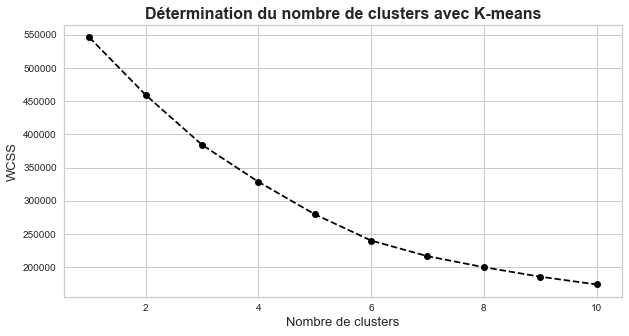

In [59]:
# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', color='black', linestyle='--')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.title('Détermination du nombre de clusters avec K-means')

Après avoir exécuté l'algorithme avec un nombre différent de clusters (10 clusters), nous déterminons le Within Cluster Sum of Squares (WCSS ou variance) pour chaque solution. Nous nous basons ensuite sur la méthode du coude pour définir le nombre de clusters optimal. Le coude se situe ici aux alentours de 6 clusters.

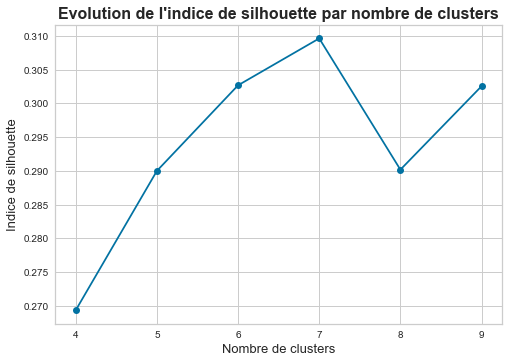

In [60]:
silhouettes_dif = []
for nb_clusters in range(4, 10):
    cls_dif = KMeans(n_clusters=nb_clusters, init='k-means++', random_state=42)
    cls_dif.fit(df_clust_std)
    silh = silhouette_score(df_clust_std, cls_dif.labels_)
    silhouettes_dif.append(silh)

plt.plot(range(4, 10), silhouettes_dif, marker='o')
plt.xticks(range(4, 10))
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de silhouette')
plt.title("Evolution de l'indice de silhouette par nombre de clusters")
plt.show()

In [61]:
# Initialisation du KMeans avec 6 clusters
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)

In [62]:
# Kmeans sur données RFM standardisées
kmeans.fit(df_clust_std)

KMeans(n_clusters=6, random_state=42)

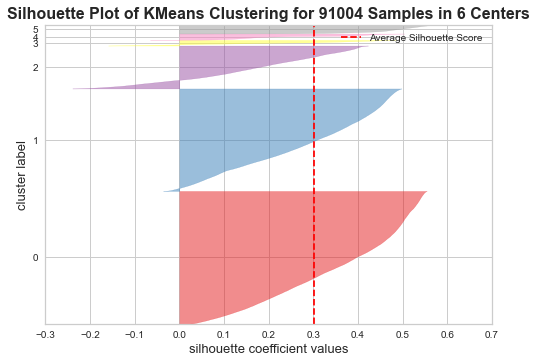

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91004 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [63]:
# Analyse des silhouettes
model = kmeans
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df_clust_std)
visualizer.poof()

L'analyse des silhouettes peut être utilisée pour évaluer la densité et la séparation entre les clusters. Le score est calculé en faisant la moyenne du coefficient de silhouette pour chaque échantillon, qui est calculé comme la différence entre la distance intra-groupe moyenne et la distance moyenne du groupe le plus proche pour chaque échantillon, normalisé par la valeur maximale. Cela produit un score entre -1 et +1, où les scores proches de +1 indiquent une séparation élevée et les scores proches de -1 indiquent que les échantillons peuvent avoir été assignés au mauvais cluster.

Le SilhouetteVisualizer affiche le coefficient de silhouette pour chaque échantillon sur une base par cluster, permettant aux utilisateurs de visualiser la densité et la séparation des clusters. Ceci est particulièrement utile pour déterminer le déséquilibre des clusters ou pour sélectionner une valeur pour K en comparant plusieurs visualisateurs.

Les silhouettes ne sont pas vraiment homogènes mais relativement longues.

In [64]:
# Ajout des clusters dans le dataframe
df_clust['Clusters_kmeans'] = kmeans.labels_

In [65]:
df_clust.head()

Recency  Frequency  Monetary  note_moy_com  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      113          1    129.90           5.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      116          1     18.90           4.0   
0000f46a3911fa3c0805444483337064      539          1     69.00           3.0   
0000f6ccb0745a6a4b88665a16c9f078      323          1     25.99           4.0   
0004aac84e0df4da2b147fca70cf8255      290          1    180.00           5.0   

                                  jrs_livr_moy_com  nb_art_moy_com  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2               6.0             1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f               3.0             1.0   
0000f46a3911fa3c0805444483337064              25.0             1.0   
0000f6ccb0745a6a4b88665a16c9f078              20.0             1.0   
0004aac84e0df4da2b147fca70cf8255              13.0             1.0   

                                  Clusters_kmeans  
customer_unique_id                                 
0000366f3b9a7992bf8c76cfdf3221e2                0  
0000b849f77a49e4a4ce2b2a4ca5be3f                0  
0000f46a3911fa3c0805444483337064                1  
0000f6ccb0745a6a4b88665a16c9f078                1  
0004aac84e0df4da2b147fca70cf8255                1

In [66]:
df_clust['Clusters_kmeans'].unique()

array([0, 1, 2, 4, 5, 3])

In [67]:
# Création d'une nouvelle colonne avec les clusters sous forme de str
df_clust['Clusters'] = df_clust['Clusters_kmeans'].map({
    0: 'Cluster_1',
    1: 'Cluster_2',
    2: 'Cluster_3',
    3: 'Cluster_4',
    4: 'Cluster_5',
    5: 'Cluster_6'})

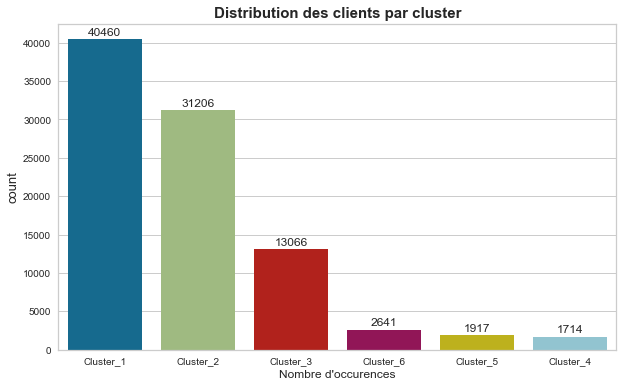

In [68]:
# Distribution des clients par cluster
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Clusters', data=df_clust,
                   order=df_clust['Clusters'].value_counts().index)
plt.title('Distribution des clients par cluster',
          fontweight='bold',
          fontsize=15)
plt.xlabel("Nombre d'occurences", fontsize=12)
etiquette_v(ax, 2)

Les clusters 1 et 2 sont largement représentés suivis du cluster 3 et des clusters 4, 5 et 6 qui sont sous représentés. Nous allons visualiser la distribution des clients de chaque cluster en fonction des variables sélectionnées.

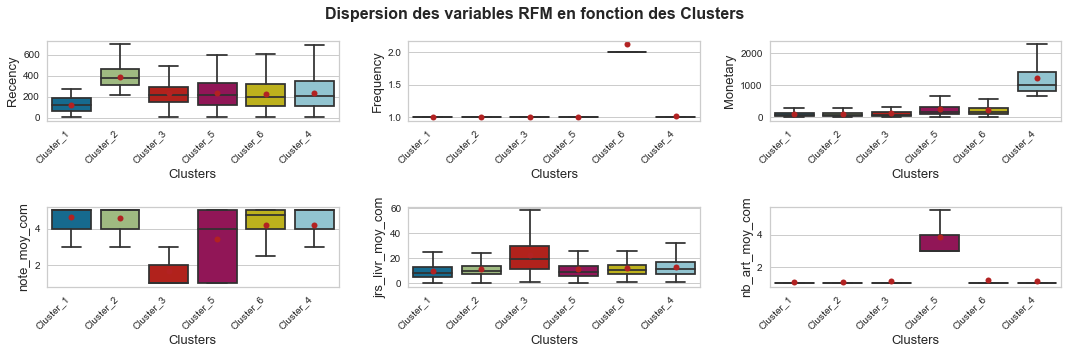

In [69]:
var = ['Recency', 'Frequency', 'Monetary', 'note_moy_com',
       'jrs_livr_moy_com', 'nb_art_moy_com']

fig = plt.figure(figsize=(15, 5))
bivariate_plots_box(df_clust, 'Clusters', var, 2, 3)

Afin de visualiser notre segmentation, réalisons un radarplot par Cluster. Voici les différentes étapes suivies:
- calcul de la moyenne de chaque variable par Cluster
- standardisation des données pour pouvoir comparer visuellement nos différents clusters
- création datadrame avec les clusters et les variables standardisées
- réalisation des radarplots par cluster

In [70]:
# Calcul de la moyenne par cluster
df_radar = df_clust[['Recency', 'Frequency', 'Monetary',
                     'note_moy_com', 'jrs_livr_moy_com',
                     'nb_art_moy_com', 'Clusters']].reset_index().groupby(
    ['Clusters']).mean()

df_radar

Recency  Frequency     Monetary  note_moy_com  jrs_livr_moy_com  \
Clusters                                                                        
Cluster_1  123.562803   1.000000   109.586588      4.644958          9.440188   
Cluster_2  391.485740   1.000000   112.873404      4.598987         11.182305   
Cluster_3  234.473672   1.000000   127.163757      1.666922         22.246058   
Cluster_4  234.446324   1.014586  1224.975957      4.195741         13.174154   
Cluster_5  236.737611   1.010433   271.737705      3.424883         11.137715   
Cluster_6  221.458160   2.111700   240.846422      4.215661         11.790879   

           nb_art_moy_com  
Clusters                   
Cluster_1        1.062729  
Cluster_2        1.066526  
Cluster_3        1.145186  
Cluster_4        1.139440  
Cluster_5        3.831508  
Cluster_6        1.178553

In [71]:
# Standardisation des données
scaler = StandardScaler()
df_radar_std = scaler.fit_transform(df_radar)
df_radar_std

array([[-1.48893714, -0.45930142, -0.59968001,  0.82847028, -0.88432735,
        -0.50192813],
       [ 1.9265383 , -0.45930142, -0.59140798,  0.78386171, -0.4703758 ,
        -0.49817593],
       [-0.07504793, -0.45930142, -0.55544301, -2.06133147,  2.15852825,
        -0.42044481],
       [-0.07539656, -0.42394037,  2.20745466,  0.39256284,  0.00291571,
        -0.42612301],
       [-0.04618729, -0.43400822, -0.19158931, -0.35545619, -0.4809709 ,
         2.23414403],
       [-0.24096938,  2.23585286, -0.26933435,  0.41189283, -0.32576991,
        -0.38747215]])

In [72]:
# Création d'un nouveau dataframe avec ajout des données standardisées
df_radar = pd.concat([df_radar.reset_index(drop=False),
                      pd.DataFrame(df_radar_std)], axis=1)

df_radar.columns.values[-6:] = ['Recency_std',
                                'Frequency_std',
                                'Monetary_std',
                                'note_moy_com_std',
                                'jrs_livr_moy_com_std',
                                'nb_art_moy_com_std']

In [73]:
df_radar

Clusters     Recency  Frequency     Monetary  note_moy_com  \
0  Cluster_1  123.562803   1.000000   109.586588      4.644958   
1  Cluster_2  391.485740   1.000000   112.873404      4.598987   
2  Cluster_3  234.473672   1.000000   127.163757      1.666922   
3  Cluster_4  234.446324   1.014586  1224.975957      4.195741   
4  Cluster_5  236.737611   1.010433   271.737705      3.424883   
5  Cluster_6  221.458160   2.111700   240.846422      4.215661   

   jrs_livr_moy_com  nb_art_moy_com  Recency_std  Frequency_std  Monetary_std  \
0          9.440188        1.062729    -1.488937      -0.459301     -0.599680   
1         11.182305        1.066526     1.926538      -0.459301     -0.591408   
2         22.246058        1.145186    -0.075048      -0.459301     -0.555443   
3         13.174154        1.139440    -0.075397      -0.423940      2.207455   
4         11.137715        3.831508    -0.046187      -0.434008     -0.191589   
5         11.790879        1.178553    -0.240969       2.235853     -0.269334   

   note_moy_com_std  jrs_livr_moy_com_std  nb_art_moy_com_std  
0          0.828470             -0.884327           -0.501928  
1          0.783862             -0.470376           -0.498176  
2         -2.061331              2.158528           -0.420445  
3          0.392563              0.002916           -0.426123  
4         -0.355456             -0.480971            2.234144  
5          0.411893             -0.325770           -0.387472

In [74]:
# Affichage des indices des colonnes
for idx, column in enumerate(df_radar.columns):
    print(idx, column)

0 Clusters
1 Recency
2 Frequency
3 Monetary
4 note_moy_com
5 jrs_livr_moy_com
6 nb_art_moy_com
7 Recency_std
8 Frequency_std
9 Monetary_std
10 note_moy_com_std
11 jrs_livr_moy_com_std
12 nb_art_moy_com_std


In [75]:
# Séléction clusters + variables std
df_radar = df_radar.iloc[:, [0, 7, 8, 9, 10, 11, 12]]
df_radar

Clusters  Recency_std  Frequency_std  Monetary_std  note_moy_com_std  \
0  Cluster_1    -1.488937      -0.459301     -0.599680          0.828470   
1  Cluster_2     1.926538      -0.459301     -0.591408          0.783862   
2  Cluster_3    -0.075048      -0.459301     -0.555443         -2.061331   
3  Cluster_4    -0.075397      -0.423940      2.207455          0.392563   
4  Cluster_5    -0.046187      -0.434008     -0.191589         -0.355456   
5  Cluster_6    -0.240969       2.235853     -0.269334          0.411893   

   jrs_livr_moy_com_std  nb_art_moy_com_std  
0             -0.884327           -0.501928  
1             -0.470376           -0.498176  
2              2.158528           -0.420445  
3              0.002916           -0.426123  
4             -0.480971            2.234144  
5             -0.325770           -0.387472

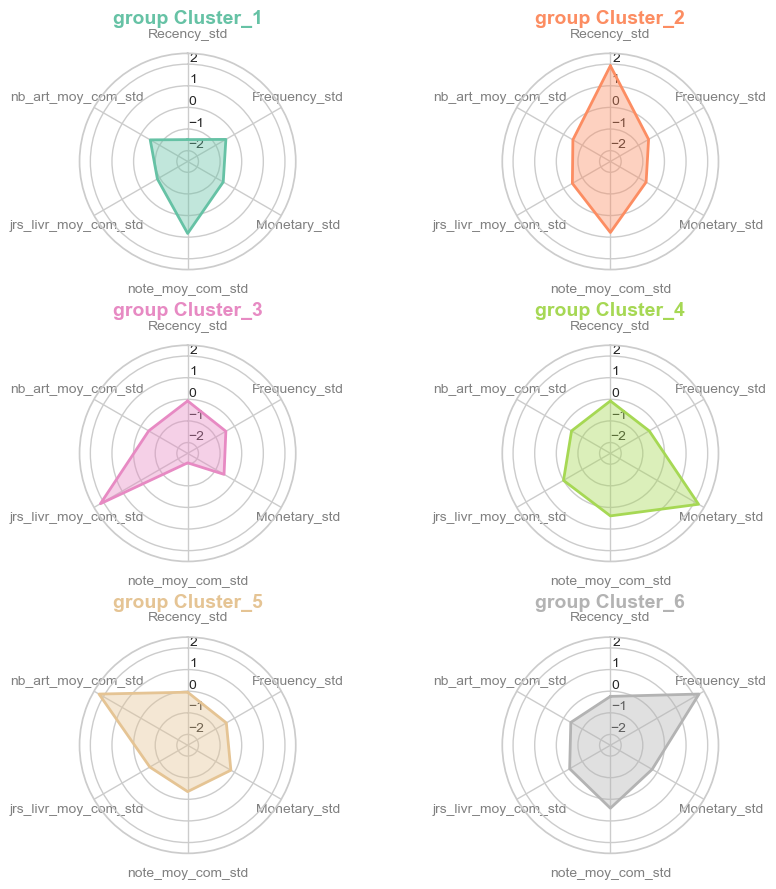

In [76]:
# Choix des données
df = df_radar

# Fonction qui réalise un plot par ligne du dataset


def radarplot(row, title, color):

    # nombre de variables
    categories = list(df)[1:]
    N = len(categories)

    # Angle de chaque axe des plots
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialisation du radarplot
    ax = plt.subplot(3, 2, row+1, polar=True, )

    # Premier axe en haut
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Un axe par variable + ajout labels
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    # Draw ylabels
    # ax.set_rlabel_position(0)
    # plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(-2.5, 2.5)

    ax.set_rlabel_position(1)

    # Ind1
    values = df.loc[row].drop('Clusters').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Ajout d'un titre
    plt.title(title, size=14, color=color, y=1.1)

    # Ajustement des subplots
    plt.subplots_adjust(left=0.125,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.35)


# Application de la fonction pour tous les individus
# Initialisation de la figure
my_dpi = 100
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
# plt.figure(figsize=(15, 22))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))

# Boucle
for row in range(0, len(df.index)):
    radarplot(row=row, title='group '+df['Clusters'][row],
              color=my_palette(row))

**Analyse des clusters:**

- Le cluster 1 représente les clients qui ont passé une seule commande avec un montant faible et qui sont satisfaits
- Le cluster 2 représente les clients qui ont passé une seule commande avec un montant faible il y a un certain temps et qui sont satisfaits
- Le cluster 3 représente les clients qui ont passé une seule commande avec un montant faible et qui ne sont pas satisfaits
- Le cluster 4 représente les clients qui ont passé une seule commande, de montant élevé et qui sont satisfaits
- Le cluster 5 représente les clients qui ont passé une seule commande de plusieurs articles, de montant faible
- Le cluster 6 représente les clients qui ont passé plusieurs commandes de montant faible et qui sont relativement satisfaits